In [1]:
import FalseColor.Color as fc
import numpy as np
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import h5py as h5
import scipy.ndimage as nd
from numba import cuda
import math
import skimage as sk
import cv2
from copy import deepcopy
import time

In [2]:
def ViewImage(Images,title=None,do_hist = False,
              figsize = (6,4), range_min=0,
              range_max=None,cmap='viridis'):
    if do_hist:
        f,ax = plt.subplots(ncols = 2,figsize = figsize)
        ax[0].imshow(Images)
        ax[0].set_title('Image')
        if range_max is None:
            range_max = Images.max()
        ax[1].hist(Images[Images != 0].ravel(),256,[range_min,range_max])
        ax[1].set_title('Histogram')
        if title is not None:
            f.suptitle(title)
    else:
        f,ax = plt.subplots(figsize=figsize)
        ax.imshow(Images,cmap=cmap)
        if title is not None:
            ax.set_title(title)
    return f,ax

In [3]:
lung_datapath = 'h5_sample_data/lung'
lung_datafile = os.path.join(lung_datapath,'lung_data.h5')
lung_h5 = h5.File(lung_datafile,'r')

In [4]:
lung_nuclei = lung_h5['t00000']['s00']['0']['cells'][:].astype(float)
lung_cyto = lung_h5['t00000']['s01']['0']['cells'][:].astype(float)
print(lung_nuclei.shape)

(17, 1024, 1024)


<IPython.core.display.Javascript object>


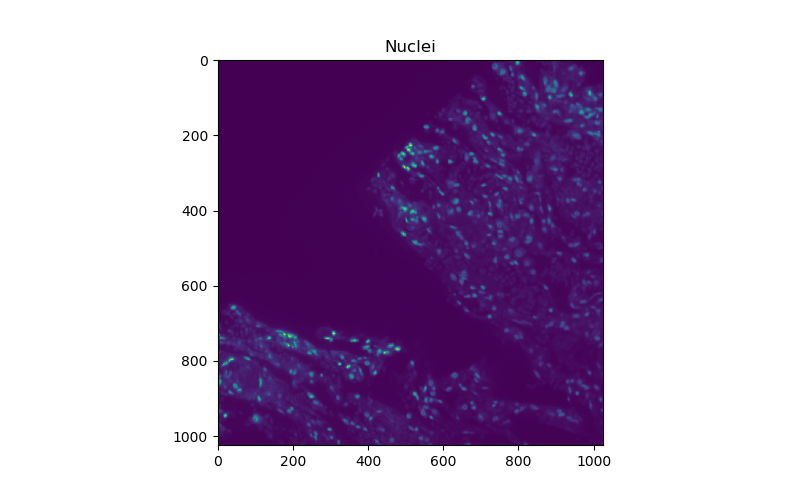

<IPython.core.display.Javascript object>


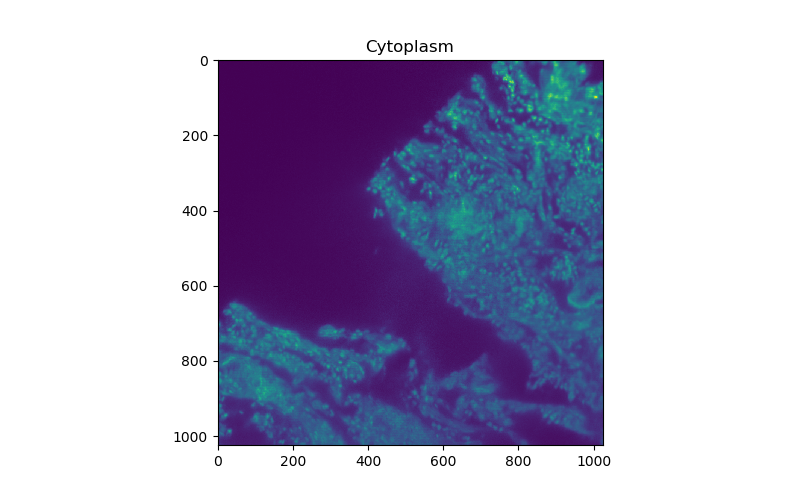

(<Figure size 800x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26674a178d0>)

In [5]:
ViewImage(lung_nuclei[0], title = 'Nuclei', figsize = (8,5))
ViewImage(lung_cyto[0], title = 'Cytoplasm', figsize = (8,5))

In [17]:
constants_nuclei = {'R' : 0.544,
                         'G' : 1.000,
                         'B' : 0.050,}

k_nuclei = 0.017
nuclei_RGBsettings = []
for value in constants_nuclei.values():
    nuclei_RGBsettings.append(value*k_nuclei)


constants_cyto = {'R' : 0.300,
                          'G' : 1.000,
                          'B' : 0.860}
k_cyto = 0.008
cyto_RGBsettings = []
for value in constants_cyto.values():
    cyto_RGBsettings.append(k_cyto*value)

In [8]:
nuc_flatfield,nuc_bg = fc.getFlatField(np.moveaxis(lung_nuclei,0,1))

In [9]:
cyto_flatfield,cyto_bg = fc.getFlatField(np.moveaxis(lung_cyto,0,1))

In [10]:
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[:,0,:], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[:,0,:], 16, order = 1, mode = 'nearest')
nuc_flatfield.shape

(1024, 1024)

In [26]:
settings_dict = fc.getDefaultRGBSettings()

In [18]:
original_settings = fc.rapidFalseColor(lung_nuclei[0],lung_cyto[0],nuclei_RGBsettings,cyto_RGBsettings,
                                       run_normalization=False)

In [24]:
pseudo_colored = []
tstart = time.time()
for i in range(len(lung_nuclei)):
    pseudo_colored.append(fc.rapidFalseColor(lung_nuclei[i],lung_cyto[i],settings_dict['nuclei'],settings_dict['cyto'],
                                            nuc_normfactor = nuc_flatfield, cyto_normfactor=cyto_flatfield,
                                            run_normalization=True))
print(time.time()-tstart)

2.5988316535949707


<IPython.core.display.Javascript object>


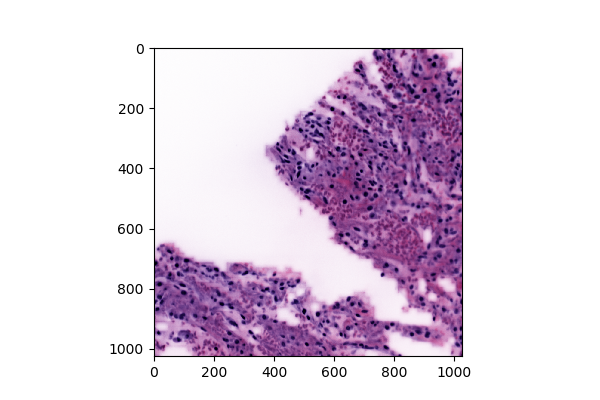

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2661e1fa940>)

In [25]:
ViewImage(pseudo_colored[10])

In [15]:
int(np.mean(lung_nuclei[10]))

824